In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch

from datasets import Dataset
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset as TorchDataset
from wordcloud import WordCloud

c:\Users\degio\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Caricamento del dataset
FFILE = "data/WELFake_Dataset.csv"

if os.path.isfile(FFILE):
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable")
else:
    print("Either the file is missing or not readable, download it")

File already exists
File is readable


In [3]:
# Lettura e analisi preliminare
df = pd.read_csv(FFILE)

print("Prime righe del dataset:\n", df.head())
print("\nColonne disponibili:", df.columns.tolist())

Prime righe del dataset:
    Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  

Colonne disponibili: ['Unnamed: 0', 'title', 'text', 'label']



Distribuzione classi:
 label
0    34790
1    28329
Name: count, dtype: int64


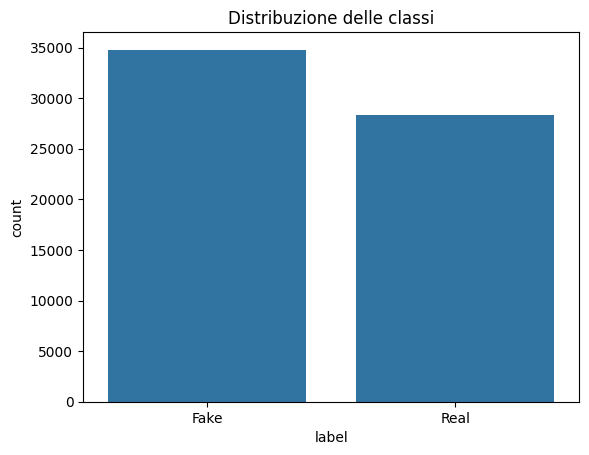

In [4]:
# Pulizia dati iniziale

# Teniamo solo le colonne rilevanti
df = df[['title', 'text', 'label']]

# Rimuove righe con valori mancanti
df = df.dropna()

# Unisce il titolo con il testo per formare una rappresentazione più ricca
df['full_text'] = df['title'].str.strip() + ". " + df['text'].str.strip()

# Converte le etichette (se non sono già int)
df['label'] = df['label'].astype(int)

# Elimina eventuali duplicati
df = df.drop_duplicates(subset='full_text')

# Distribuzione delle classi (Fake = 0, Real = 1)
print("\nDistribuzione classi:\n", df['label'].value_counts())

# Visualizzazione distribuzione classi
sns.countplot(x='label', data=df)
plt.title("Distribuzione delle classi")
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()


In [5]:
# Funzione di pulizia del testo
def clean_text(text):
    # Trasforma tutto in minuscolo
    text = text.lower()

    # Rimuove spazi multipli, tabulazioni e ritorni a capo
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Applica la pulizia al testo combinato
df['clean_text'] = df['full_text'].apply(clean_text)

In [6]:
# Split Train/Test

# Suddivide in training e test set (80% / 20%)
# stratify=y per mantenere la stessa proporzione di etichette (fake/real) nei due insiemi
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (50495,), Test shape: (12624,)


In [7]:
# Trasformazione da testo a numeri (TF-IDF)

# Calcola TF-IDF con uni-grammi e bi-grammi
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))

# Applica la trasformazione al testo pulito
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X = tfidf.transform(X)

Accuracy: 0.9465

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      6958
           1       0.94      0.94      0.94      5666

    accuracy                           0.95     12624
   macro avg       0.95      0.95      0.95     12624
weighted avg       0.95      0.95      0.95     12624


Confusion Matrix:
 [[6628  330]
 [ 345 5321]]


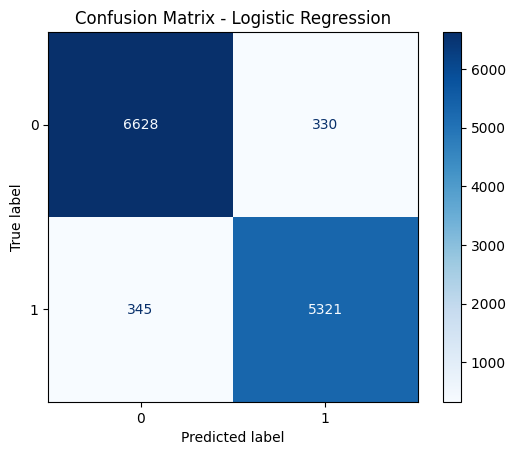

In [15]:
"""
Modello di regressione logistica
"""
model = LogisticRegression(solver='liblinear', max_iter=100)

# Allena il modello sui dati di training
model.fit(X_train, y_train)

# Previsione sul test set
y_pred_logreg = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy: {accuracy:.4f}")

# Report con precision, recall, f1-score per ogni classe
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg))

# Matrice di confusione per vedere i falsi positivi e negativi
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
print("\nConfusion Matrix:\n", conf_matrix)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Migliori parametri trovati: {'C': 1, 'penalty': 'l1'}
Migliore accuratezza in CV: 0.9507674027131399
Accuratezza sul test set: 0.9533
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      6958
           1       0.95      0.95      0.95      5666

    accuracy                           0.95     12624
   macro avg       0.95      0.95      0.95     12624
weighted avg       0.95      0.95      0.95     12624


--- VALIDAZIONE INCROCIATA (Logistic Regression GridSearch) ---
Accuratezza media (5-fold CV): 0.9523
Deviazione standard: 0.0035


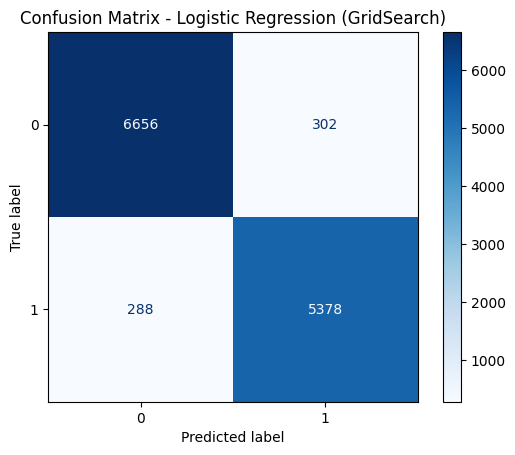

In [16]:
"""
Modello di regressione logistica (GridSearch)
"""

logreg = LogisticRegression(max_iter=100, solver='liblinear')

# Definiamo la griglia di parametri da testare
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],      # valori di regolarizzazione
    'penalty': ['l1', 'l2']            # tipo di regolarizzazione
}

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='accuracy',    
    cv=5,                  # numero di fold
    verbose=2,             # stampa il progresso
    n_jobs=-1              # usa tutti i core del processore per velocizzare
)

# Ricerca sul training set
grid_search.fit(X_train, y_train)

# Migliori parametri trovati
print("Migliori parametri trovati:", grid_search.best_params_)

# Miglior score in validazione
print("Migliore accuratezza in CV:", grid_search.best_score_)

# Valuta il modello migliore sul test set
best_model = grid_search.best_estimator_
y_pred_logreg_grid = best_model.predict(X_test)

print(f"Accuratezza sul test set: {accuracy_score(y_test, y_pred_logreg_grid):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_logreg_grid))

# Valutazione con 5-fold cross-validation su tutto il dataset
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

print("\n--- VALIDAZIONE INCROCIATA (Logistic Regression GridSearch) ---")
print(f"Accuratezza media (5-fold CV): {cv_scores.mean():.4f}")
print(f"Deviazione standard: {cv_scores.std():.4f}")

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (GridSearch)")
plt.grid(False)
plt.show()

Random Forest Accuracy: 0.9442

Classification Report Random Forest:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      6958
           1       0.94      0.93      0.94      5666

    accuracy                           0.94     12624
   macro avg       0.94      0.94      0.94     12624
weighted avg       0.94      0.94      0.94     12624



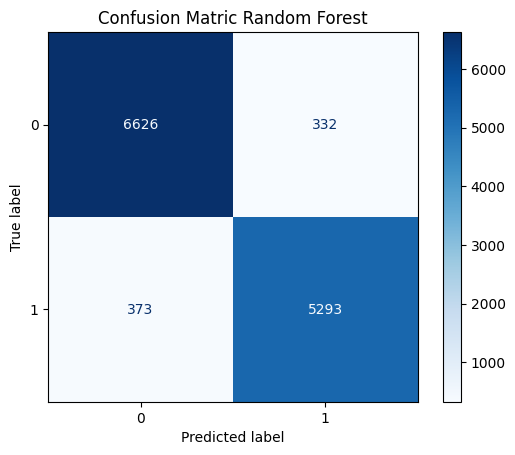

In [8]:
"""
Modello Random Forest
"""
rf_model = RandomForestClassifier(n_estimators=100, random_state=0) # n_estimators = numero di alberi nella foresta (es. 100)

# Allena il modello sui dati di training (TF-IDF + label)
rf_model.fit(X_train, y_train)

# Predice le etichette sul test set
y_pred_rf_base = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf_base)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# Report di classificazione (precision, recall, f1-score)
print("\nClassification Report Random Forest:\n", classification_report(y_test, y_pred_rf_base))

ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matric Random Forest")
plt.grid(False)
plt.show()


Fitting 4 folds for each of 12 candidates, totalling 48 fits
Migliori parametri RF: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Accuratezza RF ottimizzata: 0.9464

--- VALIDAZIONE INCROCIATA (Random Forest RandomizedSearch) ---
Accuratezza media (5-fold CV): 0.9477
Deviazione standard: 0.0050


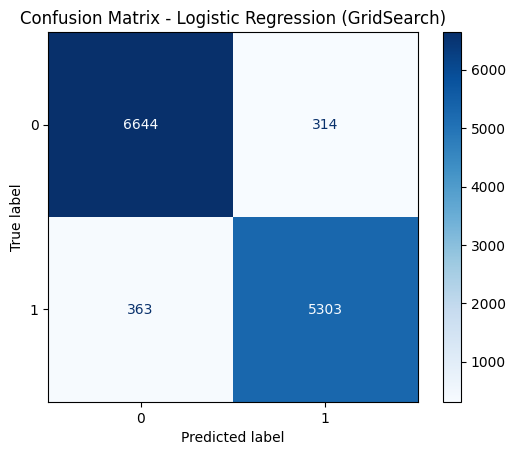

In [10]:
"""
Modelllo Random forest con randomized search
"""
# Random Forest base
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

random_search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist, 
    n_iter=12, cv=4, n_jobs=-1, verbose=2, random_state=0
)

random_search_rf.fit(X_train, y_train)

print("Migliori parametri RF:", random_search_rf.best_params_)

y_pred_rf = random_search_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuratezza RF ottimizzata: {accuracy_rf:.4f}")

# Valutazione con 5-fold cross-validation su tutto il dataset (X, y)
cv_scores = cross_val_score(random_search_rf.best_estimator_, X, y, cv=5, scoring='accuracy')

print("\n--- VALIDAZIONE INCROCIATA (Random Forest RandomizedSearch) ---")
print(f"Accuratezza media (5-fold CV): {cv_scores.mean():.4f}")
print(f"Deviazione standard: {cv_scores.std():.4f}")

ConfusionMatrixDisplay.from_estimator(random_search_rf.best_estimator_, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (GridSearch)")
plt.grid(False)
plt.show()


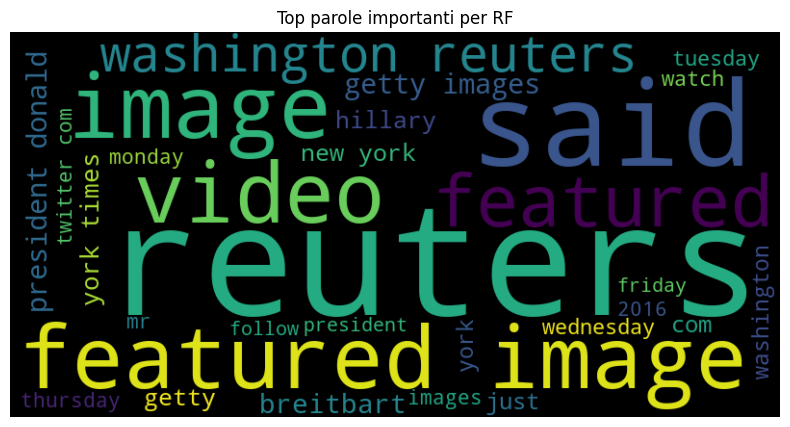

In [14]:
# Prendi le feature importanti dal modello Random Forest
importances = random_search_rf.best_estimator_.feature_importances_
top_indices = np.argsort(importances)[-30:]

feature_names = tfidf.get_feature_names_out()
top_features = {feature_names[i]: importances[i] for i in top_indices}

wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(top_features)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Top parole importanti per RF")
plt.show()


SVM Lineare - Accuracy: 0.9507287705956907
Classification Report SVM Lineare:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      6958
           1       0.94      0.95      0.95      5666

    accuracy                           0.95     12624
   macro avg       0.95      0.95      0.95     12624
weighted avg       0.95      0.95      0.95     12624



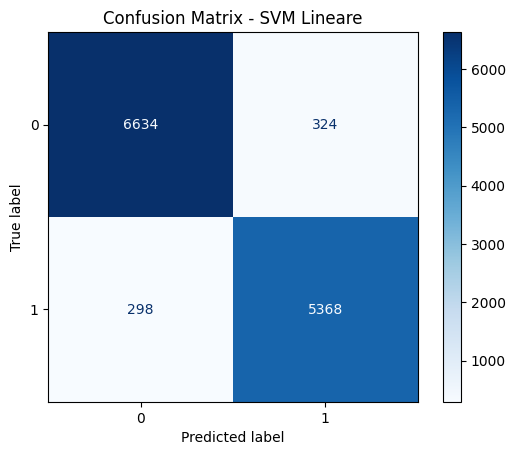

In [17]:
"""
Modello SVM lineare
"""
svm_linear = LinearSVC(random_state=0, max_iter=5000)
svm_linear.fit(X_train, y_train)

# Predizione
y_pred_linear = svm_linear.predict(X_test)

# Valutazione
print("SVM Lineare - Accuracy:", accuracy_score(y_test, y_pred_linear))
print("Classification Report SVM Lineare:\n", classification_report(y_test, y_pred_linear))

ConfusionMatrixDisplay.from_estimator(svm_linear, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - SVM Lineare")
plt.grid(False)
plt.show()


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Migliori parametri trovati: {'C': 1, 'dual': False, 'penalty': 'l2'}
Accuratezza sul test set con parametri ottimizzati: 0.9507
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      6958
           1       0.94      0.95      0.95      5666

    accuracy                           0.95     12624
   macro avg       0.95      0.95      0.95     12624
weighted avg       0.95      0.95      0.95     12624

Accuracy media CV: 0.9510, std: 0.0019


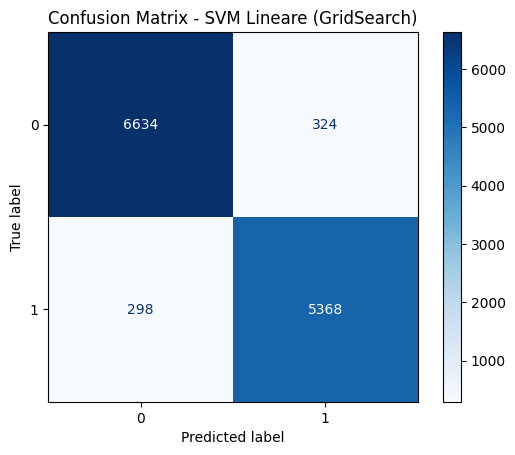

In [18]:
"""
Modello SVM con Grid Search
"""
svm = LinearSVC(random_state=0, max_iter=5000)

param_grid = {
    'C': [0.01, 0.1, 1, 10],   
    'penalty': ['l2'],         
    'dual': [False]            
}

# GridSearch con 5 fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=2)

# Esegue il fitting
grid_search.fit(X_train, y_train)

# Migliori parametri
print("Migliori parametri trovati:", grid_search.best_params_)

# Valutazione sul test set
y_pred_svm_grid = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svm_grid)
print(f"Accuratezza sul test set con parametri ottimizzati: {accuracy:.4f}")

print(classification_report(y_test, y_pred_svm_grid))

best_svm = grid_search.best_estimator_
cv_scores = cross_val_score(best_svm, X, y, cv=5, scoring='accuracy')
print(f"Accuracy media CV: {cv_scores.mean():.4f}, std: {cv_scores.std():.4f}")

ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - SVM Lineare (GridSearch)")
plt.grid(False)
plt.show()


<>:29: SyntaxWarning: invalid escape sequence '\ '
<>:29: SyntaxWarning: invalid escape sequence '\ '
C:\Users\degio\AppData\Local\Temp\ipykernel_8376\2783851619.py:29: SyntaxWarning: invalid escape sequence '\ '
  print("\ Report classificazione (Rete Neurale):")


Iteration 1, loss = 0.22419874
Validation score: 0.937030
Iteration 2, loss = 0.10624574
Validation score: 0.942376
Iteration 3, loss = 0.07550109
Validation score: 0.943762
Iteration 4, loss = 0.04700362
Validation score: 0.942574
Iteration 5, loss = 0.02560320
Validation score: 0.945149
Iteration 6, loss = 0.01116014
Validation score: 0.944752
Iteration 7, loss = 0.00459669
Validation score: 0.946139
Iteration 8, loss = 0.00304406
Validation score: 0.946535
Iteration 9, loss = 0.00257940
Validation score: 0.946139
Iteration 10, loss = 0.00223169
Validation score: 0.947723
Iteration 11, loss = 0.00163457
Validation score: 0.947525
Iteration 12, loss = 0.00162461
Validation score: 0.948119
Iteration 13, loss = 0.00118764
Validation score: 0.945941
Iteration 14, loss = 0.00129836
Validation score: 0.945941
Iteration 15, loss = 0.00098900
Validation score: 0.946535
Iteration 16, loss = 0.00093045
Validation score: 0.946733
Iteration 17, loss = 0.00072024
Validation score: 0.945941
Iterat

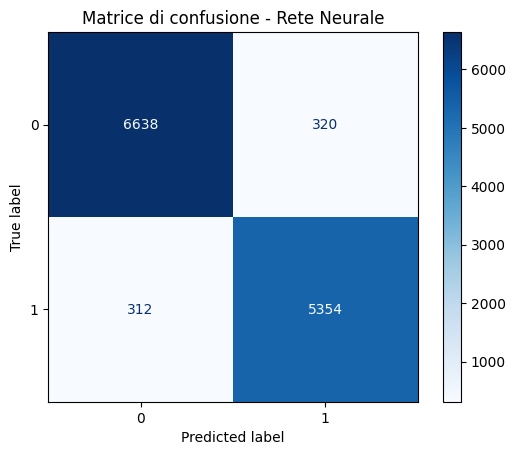

In [12]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Applica MaxAbsScaler
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definisce la rete neurale
nn_model_scaled = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Due strati nascosti: 100 e 50 neuroni
    activation='relu',             # Funzione di attivazione moderna
    solver='adam',                 # Ottimizzatore robusto
    max_iter=100,                   # Puoi aumentare se vuoi
    random_state=0,
    early_stopping=True,
    verbose=True
)

# Allena la rete
nn_model_scaled.fit(X_train_scaled, y_train)

# Predice sul test set
y_pred_nn_scaled = nn_model_scaled.predict(X_test_scaled)

# Valutazione
print("\ Report classificazione (Rete Neurale):")
print(classification_report(y_test, y_pred_nn_scaled))
print("Accuratezza:", accuracy_score(y_test, y_pred_nn_scaled))

# Matrice di confusione
ConfusionMatrixDisplay.from_estimator(nn_model_scaled, X_test_scaled, y_test, cmap='Blues')
plt.title("Matrice di confusione - Rete Neurale")
plt.grid(False)
plt.show()


In [19]:
ensemble = VotingClassifier(
    estimators=[
        ('lr', best_model),
        ('rf', random_search_rf.best_estimator_),
        ('nn', nn_model_scaled)
    ],
    voting='soft'  # Soft voting migliora se i modelli danno probabilità calibrate
)

ensemble.fit(X_train_scaled, y_train)  # NB: X_train_scaled per la NN
y_pred_ensemble = ensemble.predict(X_test_scaled)
print("Accuracy ensemble con NN (soft):", accuracy_score(y_test, y_pred_ensemble))


Iteration 1, loss = 0.22419874
Validation score: 0.937030
Iteration 2, loss = 0.10624574
Validation score: 0.942376
Iteration 3, loss = 0.07550109
Validation score: 0.943762
Iteration 4, loss = 0.04700362
Validation score: 0.942574
Iteration 5, loss = 0.02560320
Validation score: 0.945149
Iteration 6, loss = 0.01116014
Validation score: 0.944752
Iteration 7, loss = 0.00459669
Validation score: 0.946139
Iteration 8, loss = 0.00304406
Validation score: 0.946535
Iteration 9, loss = 0.00257940
Validation score: 0.946139
Iteration 10, loss = 0.00223169
Validation score: 0.947723
Iteration 11, loss = 0.00163457
Validation score: 0.947525
Iteration 12, loss = 0.00162461
Validation score: 0.948119
Iteration 13, loss = 0.00118764
Validation score: 0.945941
Iteration 14, loss = 0.00129836
Validation score: 0.945941
Iteration 15, loss = 0.00098900
Validation score: 0.946535
Iteration 16, loss = 0.00093045
Validation score: 0.946733
Iteration 17, loss = 0.00072024
Validation score: 0.945941
Iterat

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(name, y_true, y_pred, results_list):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    results_list.append({
        "Modello": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })

results = []

evaluate_model("Logistic Regression", y_test, model.predict(X_test), results)
evaluate_model("Logistic Regression (GridSearch)", y_test, best_model.predict(X_test), results)
evaluate_model("SVM Lineare", y_test, y_pred_linear, results)
evaluate_model("SVM Lineare (GridSearch)", y_test, y_pred_svm_grid, results)
evaluate_model("Random Forest (base)", y_test, rf_model.predict(X_test), results)
evaluate_model("Random Forest (ottimizzata)", y_test, random_search_rf.predict(X_test), results)
evaluate_model("Rete Neurale", y_test, y_pred_nn_scaled, results)
evaluate_model("Ensemble", y_test, y_pred_ensemble, results)

# Ordina per accuratezza (o altro)
results = sorted(results, key=lambda x: x["Accuracy"], reverse=True)

# Stampa i risultati
print(f"\n{'Modello':<35} {'Acc':<6} {'Prec':<6} {'Rec':<6} {'F1':<6}")
for r in results:
    print(f"{r['Modello']:<35} {r['Accuracy']:.4f} {r['Precision']:.4f} {r['Recall']:.4f} {r['F1-Score']:.4f}")



Modello                             Acc    Prec   Rec    F1    
Ensemble                            0.9575 0.9525 0.9527 0.9526
Logistic Regression (GridSearch)    0.9533 0.9468 0.9492 0.9480
SVM Lineare                         0.9507 0.9431 0.9474 0.9452
SVM Lineare (GridSearch)            0.9507 0.9431 0.9474 0.9452
Rete Neurale                        0.9499 0.9436 0.9449 0.9443
Logistic Regression                 0.9465 0.9416 0.9391 0.9404
Random Forest (ottimizzata)         0.9464 0.9441 0.9359 0.9400
Random Forest (base)                0.9442 0.9410 0.9342 0.9376


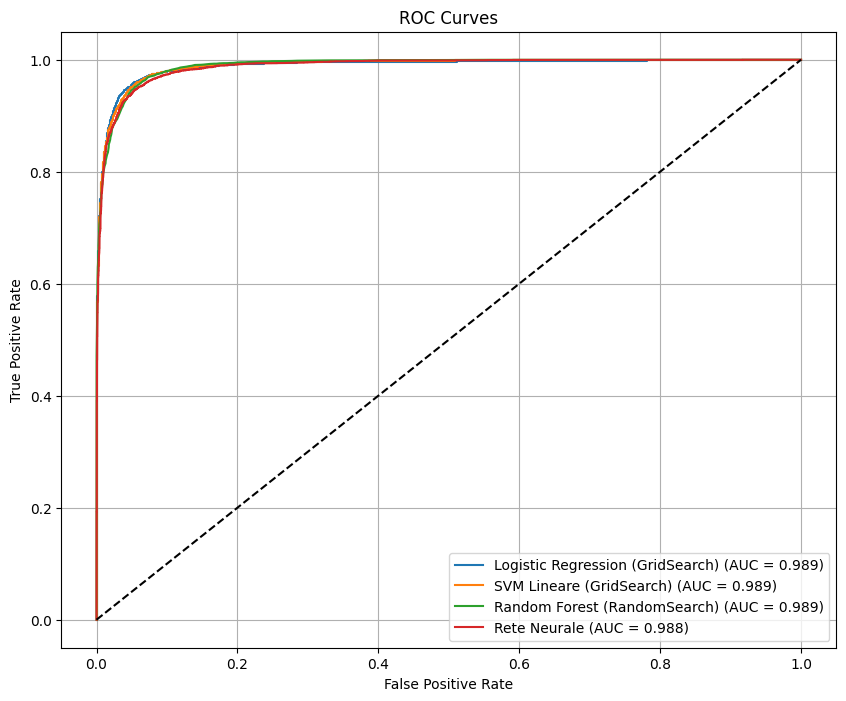

In [ ]:
# Funzione per tracciare ROC curve di più modelli
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10,8))
    
    for name, model in models.items():
        # Per modelli con metodo predict_proba (Random Forest, Logistic Regression, MLP)
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:,1]  # probabilità classe positiva
        # Per modelli che hanno decision_function (SVM)
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        else:
            print(f"{name} non ha predict_proba o decision_function, salto ROC")
            continue
        
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc_score = roc_auc_score(y_test, y_scores)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")
    
    # Diagonale casuale
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Definisce i modelli migliori (quelli con parametri ottimizzati)
models = {
    "Logistic Regression (GridSearch)": best_model,
    "SVM Lineare (GridSearch)": best_svm,
    "Random Forest (RandomSearch)": random_search_rf.best_estimator_,
    "Rete Neurale": nn_model_scaled
}

plot_roc_curves(models, X_test, y_test)


In [22]:
### BERT
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Tokenizer BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

# Dataset personalizzato
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = FakeNewsDataset(X_train_bert, y_train_bert, tokenizer)
test_dataset = FakeNewsDataset(X_test_bert, y_test_bert, tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
X_train_small = X_train_bert[:1000]
y_train_small = y_train_bert[:1000]
X_test_small = X_test_bert[:200]
y_test_small = y_test_bert[:200]


train_dataset = FakeNewsDataset(X_train_small, y_train_small, tokenizer)
test_dataset = FakeNewsDataset(X_test_small, y_test_small, tokenizer)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,   # invece di 4
    per_device_eval_batch_size=8,
    warmup_steps=50,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    save_strategy="epoch",
    metric_for_best_model="eval_f1",
    greater_is_better=True,
)


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.199100,0.163114,0.970000,0.967033,0.946237,0.988764
2,0.019900,0.114806,0.975000,0.971429,0.988372,0.955056


TrainOutput(global_step=500, training_loss=0.18998092002049088, metrics={'train_runtime': 9789.9691, 'train_samples_per_second': 0.204, 'train_steps_per_second': 0.051, 'total_flos': 526222110720000.0, 'train_loss': 0.18998092002049088, 'epoch': 2.0})